## Setup

In [ ]:
# ---------------------------------------------------
# 📦 LIBRERÍAS
# ---------------------------------------------------
from google.cloud import bigquery
from io import BytesIO
from PIL import Image
from google.api_core import exceptions
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload, MediaIoBaseUpload
from google import genai
from google.genai.types import Part, GenerateContentConfig
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google import auth
from pathlib import Path
# ---------------------------------------------------

# 📦 Parámetros de configuración

PROJECT = "lmes-aiforlmes-d-f86"
LOCATION = "europe-west1"
AI_MODEL_NAME = "gemini-2.5-flash-image"
MODEL_SELECT_IMAGE = "gemini-2.5-flash"
FOLDER_IMAGES = "./imagenes_dameo_cotas/"
DRIVE_FOLDER_NAME = "Pruebas_cotas"
# reference = 97976348
reference = 98935772
# reference = 98935773
# reference =  98085961 # no carac
# reference = 94031529 # no carac
# reference = 94301837

# path_img = "pruebas_imagenes/97976348-p-01.jpg"
# path_img = "pruebas_imagenes/98935772-p-03.jpg"
# path_img = "pruebas_imagenes/98935773-p-02.jpg"
# path_img = "pruebas_imagenes/98085961-p-02.jpg" # no carac 
# path_img= "pruebas_imagenes/94031529-p-01.jpg"
# path_img = "pruebas_imagenes/94301837-p-03.tif.jpg"

genai_client = genai.Client(vertexai=True, project=PROJECT, location="us-central1")

client = bigquery.Client(project=PROJECT, location="EU")

# Usa las credenciales configuradas con gcloud auth application-default login
# Los scopes ya están incluidos en las credenciales ADC
creds, _ = auth.default()
drive_service = build('drive', 'v3', credentials=creds)

## Prompts, funciones auxiliares,  y queries

### Prompts

In [68]:
PICTOGRAM_PROMPT = """
=== TASK: CREATE TECHNICAL DRAWING ===

--- CORE INSTRUCTION ---
Your goal is to create a highly detailed, black and white line art illustration of the product based on the provided reference image, and then accurately overlay precise dimension lines and labels as specified in the "ADD DIMENSIONS" section.
--- STYLE GUIDELINES (Base Illustration) ---
1.  **Line Art:** Generate a clean, crisp, black and white line drawing for the product. No colors, no shadows, no fills, no gradientsm no sparkles.
2.  **Detail Level:** Emphasize an extremely high level of detail. Trace the reference image as if converting a photograph into a precise technical drawing.
3.  **Perspective:** Maintain the exact perspective and angle of the object as seen in the reference image.
--- CONTENT GUIDELINES (Base Illustration) ---
1.  **Product Only:** The illustration must only depict the product itself.
--- OUTPUT GUIDELINES (Base Illustration) ---
1.  **Canvas Containment:** Ensure the entire product illustration is fully contained within the image canvas, leaving ample space for dimensions.
"""

ADD_DIMENSIONS_PROMPT = """
=== TASK: ADD TECHNICAL DIMENSION LINES TO EXISTING PICTOGRAM ===

--- INPUT PROVIDED ---
1. **Pictogram Image**: The pictogram image
2. **Visible Dimensions**: Specific dimensions visible in this view (width, height, and/or depth)
3. **Dimension Values**: Exact measurements with units

--- CRITICAL REQUIREMENTS ---

**PRESERVE PICTOGRAM:**
✓ Only ADD dimension lines and text on the existing pictogram
✓ Do NOT redraw or modify the product illustration

**DIMENSION LINE STYLE:**

**IMPORTANT: Each dimension must consist of EXACTLY these components:**

1. **Dimension Line (ONE per dimension):**
   - ONE single continuous line from the edges of the product dimension being measured
   - Parallel to the dimension being measured
   - Solid black color

2. **Arrowheads (TWO per dimension line):**
    - ONE arrowhead at EACH end of the dimension line
    - Aligned with dimension line direction

3. **Text Label (ONE per dimension):**
    - Format: "[VALUE] [UNIT]" (e.g., "105 cm", "137,8 cm", "48 cm")
    - Position: Centered on or slightly above the dimension line
    - Font: Arial or Helvetica, sans-serif
    - Size: Readable 
    - Color: Solid black 

**DIMENSION LINE EXAMPLE:**

```
Product edge ──┐
               │
               │
    ◄──────────┼──────────► ← Dimension line with TWO arrowheads
               │            Text: "VALUE UNIT" centered above
               │
Product edge ──┘ 
```

**TEXT ORIENTATION:**
- **Horizontal dimensions (width):** Text horizontal, readable from bottom
- **Vertical dimensions (height):** Text rotated 90° counterclockwise, readable from right side
- **Angled dimensions (depth):** Text parallel to dimension line, readable when viewed along the line

**DECIMAL SEPARATOR:**
- Use COMMA (,) as decimal separator (e.g., "137,8 cm" NOT "137.8 cm")

--- MANDATORY CONSTRAINTS ---

✓ Add EXACTLY ONE dimension line per measurement
✓ Each dimension line must have EXACTLY TWO arrowheads (one at each end)
✓ Use EXACT values provided (do NOT round or modify)
✓ Always include the unit of measure (cm, mm, etc.)
✓ Use COMMA (,) as decimal separator
✓ Add ONLY the dimensions marked as visible
✓ If a value is missing, empty, or "N/A", SKIP that dimension entirely
✓ Ensure dimension lines do NOT overlap with:
  - Product illustration
  - Other dimension lines
  - Text labels
✓ Maintain professional, clean appearance with adequate spacing

--- COMMON MISTAKES TO AVOID ---

✗ Drawing multiple dimension lines for the same measurement
✗ Missing arrowheads on dimension lines
✗ Using dots (.) instead of commas (,) for decimals
✗ Placing text perpendicular to the dimension line
✗ Overlapping dimension lines
✗ Dimension lines too close to the product

"""

SELECT_BETTER_IMAGE_PROMPT = """
=== TASK: SELECT THE BEST IMAGE FOR ADDING TECHNICAL DIMENSION LINES ===

You are an expert image analyst specializing in technical drawings and product dimensioning. 
You are provided with multiple images of a product. Your task is to:
1. Select the SINGLE BEST image for adding technical dimension lines (cotas técnicas)
2. Determine if 3D dimensioning is possible or if only 2D dimensioning can be applied
3. Provide reasoning for your selection

--- SELECTION CRITERIA (Priority Order) ---

**PRIORITY 1 - 3D PERSPECTIVE (PREFERRED):**
✓ Images showing the product from an isometric, oblique, or three-quarter view angle
✓ Multiple visible faces/sides of the product (ideally showing width, height, AND depth simultaneously)
✓ Clear depth perception and spatial relationships between product components
✓ Visible corners or edges that reveal the product's three-dimensional form
✓ Perspective that allows placement of dimension lines in all three axes (X, Y, Z)

**PRIORITY 2 - CLEAR 2D VIEW (ACCEPTABLE IF 3D NOT AVAILABLE):**
✓ Front, side, or top orthogonal views with clear, unobstructed product outline
✓ Flat perspective showing two primary dimensions clearly (e.g., width × height OR width × depth)
✓ Minimal foreshortening or perspective distortion
✓ Clean background that won't interfere with dimension line placement

**GENERAL QUALITY REQUIREMENTS:**
✓ High resolution and sharp focus (no blur)
✓ Good lighting with clear visibility of product edges and contours
✓ Product fully visible within the frame (not cropped or cut off)
✓ Sufficient white space/margins around the product for dimension line annotations
✓ Clean, uncluttered background (preferably white or neutral)
✓ No overlapping objects, hands, or other distracting elements

**AVOID:**
✗ Extreme close-ups showing only partial product details
✗ Images with heavy shadows, glare, or poor lighting
✗ Perspective angles that hide critical dimensions
✗ Low-resolution or blurry images
✗ Images with busy backgrounds or overlapping products

--- OUTPUT FORMAT (JSON) ---

Respond ONLY with valid JSON in this exact format:

{
    "selected_index": <integer from 1 to N>,
    "dimensioning_type": "<3D or 2D>",
    "can_add_3d_dimensions": <true or false>,
    "confidence": "<high, medium, or low>",
    "reasoning": "<concise explanation of why this image was selected and why it supports 3D or only 2D dimensioning>",
    "visible_dimensions": {
        "width": <true or false>,
        "height": <true or false>,
        "depth": <true or false>
    },
    "quality_score": <integer from 1 to 10>,
    "alternative_suggestions": "<optional: if selected image is suboptimal, suggest which other image index might work better for specific use cases>"
}

--- DECISION LOGIC ---

**IF 3D perspective is available:**
- Set "dimensioning_type": "3D"
- Set "can_add_3d_dimensions": true
- All three dimensions (width, height, depth) should be marked as visible
- Confidence should be "high" if perspective is clear

**IF only 2D views are available:**
- Set "dimensioning_type": "2D"
- Set "can_add_3d_dimensions": false
- Mark only the two visible dimensions as true
- Select the view that shows the MOST IMPORTANT dimensions (usually front view with width × height)

**EXAMPLE SCENARIOS:**

Example 1 - 3D Perspective Available:
{
    "selected_index": 2,
    "dimensioning_type": "3D",
    "can_add_3d_dimensions": true,
    "confidence": "high",
    "reasoning": "Image 2 shows an isometric view with clear visibility of all three dimensions. The product is photographed from a three-quarter angle, allowing simultaneous display of width, height, and depth. Good lighting and margins for dimension lines.",
    "visible_dimensions": {"width": true, "height": true, "depth": true},
    "quality_score": 9,
    "alternative_suggestions": ""
}

Example 2 - Only 2D View Available:
{
    "selected_index": 1,
    "dimensioning_type": "2D",
    "can_add_3d_dimensions": false,
    "confidence": "medium",
    "reasoning": "All images show flat orthogonal views. Image 1 (front view) is selected as it clearly displays width and height dimensions. Depth is not visible from this angle. Image quality is good but limited to 2D dimensioning.",
    "visible_dimensions": {"width": true, "height": true, "depth": false},
    "quality_score": 7,
    "alternative_suggestions": "If depth dimension is critical, consider obtaining an additional image with 3D perspective."
}

--- IMPORTANT NOTES ---
- Always prioritize 3D perspective images when available
- If multiple 3D images exist, choose the one with the clearest view and best lighting
- Be conservative: only mark can_add_3d_dimensions as true if depth is genuinely visible and measurable
- The selected image must allow clear placement of dimension lines WITHOUT obscuring the product
"""

### Queries

In [3]:

# sql_opus_dimensiones = f"""
# SELECT productReferenceBu, t.type, media_item.type, media_item.url, media_item.label
# FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_MEDIA_V1_com_adeo_CatalogsBroadcast_ProductCoreMediaValue` as t,
# UNNEST(media) AS media_item
# WHERE TIMESTAMP_TRUNC(_PARTITIONTIME, DAY) = TIMESTAMP("2025-09-19") and media_item.type = "photo"
# """
# opus_dimensiones = client.query(sql_opus_dimensiones).to_dataframe()
# opus_dimensiones
sql_dimension_reference = f"""
SELECT 
    productReferenceBu, att.code as code_char, att.name as name_char, d.value.double as value_char
FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_ATTRIBUTE_V1_com_adeo_CatalogsBroadcast_ProductCoreAttributeValue`,
    UNNEST(attributes) AS att,
    UNNEST(att.data) AS d
WHERE TIMESTAMP_TRUNC(_PARTITIONTIME, DAY) 
  BETWEEN TIMESTAMP("2025-11-19") AND TIMESTAMP("2025-12-20") and
  # Altura en cm, Ancho en cm, Profundidad en cm, Altura total en cm, Anchura total en cm, Profundidad total en cm
  att.code in("00053","00054", "00055", "00640", "03650", "14266") 
  and productReferenceBu = cast({reference} as STRING)
"""

sql_mod_from_reference = f"""
SELECT
     cod_mod 
FROM 
    `dfdp-teradata6y.ProductFeaturesLmes.TDGEN_PVTPRD_ART`
where
    num_art = {reference}
 """

sql_get_images_dameo = f"""
SELECT
    productId, mediaLinkUrl
FROM 
    `dfdp-dameo-data.productMediaLink.product_media_link` 
where 
    bu = 2 and productId = {reference} and mediatype = "IMG" and mediaCategory = "P"
"""

### Funciones auxiliares

In [ ]:
def get_better_image_to_add_pattern(image_parts):
    """GDevuelve la imagen para generar cotas con el mejor encuadre"""
    full_prompt = SELECT_BETTER_IMAGE_PROMPT

    # Preparar contenido para la API
    contents = [Part.from_text(text=full_prompt)] + image_parts
    
    try:
        # Generar respuesta
        response = genai_client.models.generate_content(
            model=MODEL_SELECT_IMAGE,
            contents=contents,
            config=GenerateContentConfig(
                temperature=0,  # Baja temperatura para respuestas más deterministas
                response_mime_type="application/json"
            )
        )
        
        result = json.loads(response.text)
        
        # Convertir a 0-indexed
        result['selected_index'] = result.get('selected_index', 1) - 1
        
        # Mostrar información detallada
        print("=" * 80)
        print(f"✅ IMAGEN SELECCIONADA: {result['selected_index'] + 1}/{len(image_parts)//2}")
        print("=" * 80)
        print(f"📐 Tipo de dimensionamiento: {result.get('dimensioning_type', 'N/A')}")
        print(f"🎯 ¿Puede añadir cotas 3D?: {'SÍ' if result.get('can_add_3d_dimensions') else 'NO'}")
        print(f"🔍 Confianza: {result.get('confidence', 'N/A')}")
        print(f"⭐ Puntuación de calidad: {result.get('quality_score', 'N/A')}/10")
        print(f"\n📝 Razón:")
        print(f"   {result.get('reasoning', 'N/A')}")
        
        visible_dims = result.get('visible_dimensions', {})
        print(f"\n📏 Dimensiones visibles:")
        print(f"   • Anchura: {'✓' if visible_dims.get('width') else '✗'}")
        print(f"   • Altura: {'✓' if visible_dims.get('height') else '✗'}")
        print(f"   • Profundidad: {'✓' if visible_dims.get('depth') else '✗'}")
        
        if result.get('alternative_suggestions'):
            print(f"\n💡 Sugerencias alternativas:")
            print(f"   {result.get('alternative_suggestions')}")
        
        print("=" * 80)
        
        return result
        
    except Exception as e:
        print(f"⚠️ Error al seleccionar imagen: {e}")
        raise

def get_pictogram_from_image(image: Image.Image) -> Image.Image:
    """Genera un pictograma lineal a partir de una imagen de producto.
    
    Args:
        image: Imagen PIL del producto
    
    Returns:
        Respuesta de la API con la imagen generada
    """
    
    full_prompt = PICTOGRAM_PROMPT
    
    # Convertir la imagen PIL a bytes en formato PNG
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()  # Obtener los bytes
    
    contents = [
        Part.from_text(text=full_prompt), 
        Part.from_bytes(data=img_byte_arr, mime_type="image/png")
    ]
    
    try:
        response = genai_client.models.generate_content(
            model=AI_MODEL_NAME,
            contents=contents,
            config=GenerateContentConfig(
                temperature=0,  # Determinístico para resultados consistentes
            )
        )
        return response
    
    except Exception as e:
        print(f"⚠️ Error al generar pictograma: {e}")
        raise

def get_dimensions_added_from_pictogram(
    dimensiones: dict, 
    image: Image.Image, 
    visible_dimensions: dict
) -> Image.Image:
    """
    Añade cotas técnicas a una imagen basándose en las dimensiones visibles.
    
    Args:
        dimensiones: Diccionario con todas las dimensiones disponibles
            Ejemplo: {'Altura (en cm)': 137.8, 'Anchura (en cm)': 105, 'Profundidad (en cm)': 48}
        image: Imagen PIL del producto
        visible_dimensions: Diccionario indicando qué dimensiones son visibles
            Ejemplo: {"width": True, "height": True, "depth": False}
    
    Returns:
        Respuesta de la API con la imagen generada
    """
    
    # Mapeo de dimensiones visibles a nombres de características (normalizado)
    dimension_mapping = {
        "width": ["Ancho", "Anchura", "ancho", "anchura", "width"],
        "height": ["Altura", "Alto", "altura", "alto", "height"],
        "depth": ["Profundidad", "Fondo", "profundidad", "fondo", "depth"]
    }
    
    # Filtrar solo las dimensiones visibles
    visible_dims = {}
    
    for dim_key, is_visible in visible_dimensions.items():
        if is_visible:
            # Buscar el valor correspondiente en el diccionario de dimensiones
            for possible_name in dimension_mapping.get(dim_key, []):
                # Buscar coincidencia parcial en las claves del diccionario
                for dimension_name, dimension_value in dimensiones.items():
                    if possible_name.lower() in dimension_name.lower():
                        # Formatear el valor
                        if isinstance(dimension_value, float):
                            # Mantener decimales si existen, sino mostrar como entero
                            value = int(dimension_value) if dimension_value.is_integer() else round(dimension_value, 1)
                        else:
                            value = dimension_value
                        
                        # Extraer la unidad del nombre de la dimensión
                        unit = "cm"  # Por defecto
                        if "(en cm)" in dimension_name or "(cm)" in dimension_name:
                            unit = "cm"
                        elif "(en mm)" in dimension_name or "(mm)" in dimension_name:
                            unit = "mm"
                        elif "(en m)" in dimension_name or "(m)" in dimension_name:
                            unit = "m"
                        
                        visible_dims[dim_key] = {
                            "name": dimension_name,
                            "value": value,
                            "unit": unit,
                            "formatted": f"{value} {unit}"
                        }
                        break
                if dim_key in visible_dims:
                    break
    
    # Construir el prompt con las dimensiones visibles
    prompt_text = ADD_DIMENSIONS_PROMPT
    
    if not visible_dims:
        print("⚠️ No hay dimensiones visibles para añadir")
        return None
    
    # Añadir información sobre las dimensiones visibles
    dim_count = len(visible_dims)
    view_type = "3D" if dim_count == 3 else "2D"
    
    prompt_text += f"\n**View Type**: {view_type} perspective ({dim_count} dimension{'s' if dim_count > 1 else ''} visible)\n\n"
    prompt_text += "**Dimensions to add:**\n\n"
    
    # Listar dimensiones visibles con instrucciones específicas
    if "width" in visible_dims:
        dim_info = visible_dims["width"]
        prompt_text += f"• **Width (Ancho)**: {dim_info['formatted']}\n"
        prompt_text += f"  → Placement: Horizontal line BELOW the product\n"
        prompt_text += f"  → Arrow direction: ←──────→ (left-right arrows)\n"
        prompt_text += f"  → Text: Horizontal, centered below dimension line\n\n"
    
    if "height" in visible_dims:
        dim_info = visible_dims["height"]
        prompt_text += f"• **Height (Altura)**: {dim_info['formatted']}\n"
        prompt_text += f"  → Placement: Vertical line on LEFT or RIGHT side\n"
        prompt_text += f"  → Arrow direction: ↑──────↓ (up-down arrows)\n"
        prompt_text += f"  → Text: Rotated 90° vertical, centered along line\n\n"
    
    if "depth" in visible_dims:
        dim_info = visible_dims["depth"]
        prompt_text += f"• **Depth (Profundidad)**: {dim_info['formatted']}\n"
        prompt_text += f"  → Placement: Diagonal/isometric line showing depth axis\n"
        prompt_text += f"  → Arrow direction: Following perspective angle\n"
        prompt_text += f"  → Text: Angled parallel to dimension line\n\n"
    
    prompt_text += "\n--- FINAL REMINDERS ---\n"
    prompt_text += f"• Keep THE PICTOGRAM INTACT (do NOT redraw)\n"
    prompt_text += f"• Use EXACT values: {', '.join([v['formatted'] for v in visible_dims.values()])} with , as the decimal separator\n"
    prompt_text += f"• Add ONLY these {dim_count} dimension{'s' if dim_count > 1 else ''} (no extras and only add one line for each dimension)\n"
    prompt_text += f"• Ensure clean, professional appearance\n"
    
    # Imprimir información de debug
    print("=" * 80)
    print(f"📏 AÑADIENDO COTAS TÉCNICAS")
    print("=" * 80)
    print(f"🎯 Tipo de vista: {view_type}")
    print(f"📐 Dimensiones a añadir:")
    for dim_key, dim_info in visible_dims.items():
        print(f"   • {dim_info['name']}: {dim_info['formatted']}")
    print("=" * 80)
    
    
    # Convertir la imagen PIL a bytes en formato PNG
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()  # Obtener los bytes
    
    contents = [
        Part.from_text(text=prompt_text), 
        Part.from_bytes(data=img_byte_arr, mime_type="image/png")
    ]
    
    try:
        response = genai_client.models.generate_content(
            model=AI_MODEL_NAME,
            contents=contents,
            config=GenerateContentConfig(
                temperature=0,  # Determinístico para resultados consistentes
            )
        )
        print(prompt_text)
        return response
    
    except Exception as e:
        print(f"❌ Error al generar imagen con cotas: {e}")
        raise

def download_image_from_url(url):
    try:
        response = requests.get(url, timeout=20)
        response.raise_for_status()
        image_bytes = response.content
        image = Image.open(BytesIO(image_bytes))
        mime_type = "image/jpeg" if image.format.lower() in ["jpeg", "jpg"] else "image/png"
        return image_bytes, mime_type
    except Exception as e:
        print(f"       ⚠️ Error al descargar imagen {url}: {e}")
        return None, None

def get_drive_folder_id(folder_name, is_shared_drive=True):
    """
    Busca una carpeta en Google Drive por nombre.
    
    Args:
        folder_name: Nombre de la carpeta a buscar
        is_shared_drive: Si True, busca en unidades compartidas (Shared Drives)
    """
    query = f"mimeType='application/vnd.google-apps.folder' and name='{folder_name}' and trashed=false"
    
    try:
        # Configurar parámetros según si es shared drive o no
        params = {
            'q': query,
            'spaces': 'drive',
            'fields': 'files(id, name, driveId)',
            'supportsAllDrives': True,  # Clave para acceder a shared drives
            'includeItemsFromAllDrives': True  # Incluir archivos de todas las unidades
        }
        
        response = drive_service.files().list(**params).execute()
        folders = response.get('files', [])
        
        if folders:
            print(f"✅ Carpeta '{folder_name}' encontrada: {folders[0]['id']}")
            if 'driveId' in folders[0]:
                print(f"   📂 En unidad compartida: {folders[0]['driveId']}")
            return folders[0]['id']
        else:
            print(f"⚠️ Carpeta '{folder_name}' no encontrada")
            print(f"   💡 Verificando unidades compartidas disponibles...")
            
            # Listar unidades compartidas disponibles
            drives_response = drive_service.drives().list().execute()
            drives = drives_response.get('drives', [])
            
            if drives:
                print(f"   📋 Unidades compartidas disponibles:")
                for drive in drives:
                    print(f"      • {drive['name']} (ID: {drive['id']})")
            else:
                print(f"   ⚠️ No tienes acceso a ninguna unidad compartida")
            
            return None
            
    except Exception as e:
        print(f"❌ Error al buscar carpeta: {e}")
        return None


def get_or_create_drive_subfolder(subfolder_name, parent_folder_id):
    """Crea o encuentra una subcarpeta dentro de una carpeta padre (compatible con Shared Drives)"""
    print(f"   🔍 Buscando subcarpeta '{subfolder_name}'...")
    query = f"mimeType='application/vnd.google-apps.folder' and name='{subfolder_name}' and '{parent_folder_id}' in parents and trashed=false"
    
    try:
        response = drive_service.files().list(
            q=query,
            spaces='drive',
            fields='files(id, name)',
            supportsAllDrives=True,
            includeItemsFromAllDrives=True
        ).execute()
        
        folders = response.get('files', [])
        
        if folders:
            print(f"   ✅ Subcarpeta encontrada: {folders[0]['id']}")
            return folders[0]['id']
        else:
            print(f"   📁 Creando nueva subcarpeta '{subfolder_name}'...")
            file_metadata = {
                'name': subfolder_name,
                'mimeType': 'application/vnd.google-apps.folder',
                'parents': [parent_folder_id]
            }
            
            folder = drive_service.files().create(
                body=file_metadata,
                fields='id',
                supportsAllDrives=True  # Importante para shared drives
            ).execute()
            
            print(f"   ✅ Subcarpeta creada: {folder.get('id')}")
            return folder.get('id')
            
    except Exception as e:
        print(f"   ❌ Error al buscar/crear subcarpeta: {e}")
        raise


def upload_image_to_drive_from_memory(image: Image.Image, file_name: str, folder_id: str):
    """
    Sube una imagen PIL directamente a Google Drive desde memoria (compatible con Shared Drives).
    
    Args:
        image: Imagen PIL a subir
        file_name: Nombre del archivo en Drive
        folder_id: ID de la carpeta de destino en Drive
    
    Returns:
        dict con 'id', 'webViewLink' y 'webContentLink'
    """
    # Convertir imagen PIL a bytes en memoria
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr.seek(0)  # Volver al inicio del buffer
    
    # Metadatos del archivo
    file_metadata = {
        "name": file_name,
        "parents": [folder_id]
    }
    
    # Subir usando MediaIoBaseUpload (no requiere archivo en disco)
    media = MediaIoBaseUpload(img_byte_arr, mimetype="image/png", resumable=True)
    
    try:
        file = drive_service.files().create(
            body=file_metadata,
            media_body=media,
            fields="id, webViewLink, webContentLink",
            supportsAllDrives=True  # Clave para shared drives
        ).execute()
        
        print(f"   ✅ Imagen '{file_name}' subida correctamente")
        print(f"      📎 ID: {file.get('id')}")
        print(f"      🔗 Ver: {file.get('webViewLink')}")
        
        return file
        
    except Exception as e:
        print(f"   ❌ Error subiendo imagen: {e}")
        raise

## Selcionar imagen a añadir cotas

/home/diego/.cache/pypoetry/virtualenvs/notebook-sy5XO1w4-py3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


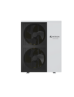

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1f5gy7qs8xuuj1ietgznwrfsa1ce con tipo MIME image/png


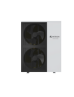

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1f5gy7qs8xuuj1skwhzxeoyjydge con tipo MIME image/png


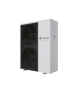

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1f5gy7qs8xuuj1ism75xjifjtery con tipo MIME image/png
✅ IMAGEN SELECCIONADA: 3/3
📐 Tipo de dimensionamiento: 3D
🎯 ¿Puede añadir cotas 3D?: SÍ
🔍 Confianza: high
⭐ Puntuación de calidad: 9/10

📝 Razón:
   Image 3 presents an excellent isometric (three-quarter) view of the product, clearly displaying its width, height, and depth simultaneously. This perspective is ideal for adding technical dimension lines in all three axes (X, Y, Z). The image quality is high, with sharp focus, good lighting, and sufficient white space around the product for annotations, making it the best choice for comprehensive dimensioning.

📏 Dimensiones visibles:
   • Anchura: ✓
   • Altura: ✓
   • Profundidad: ✓


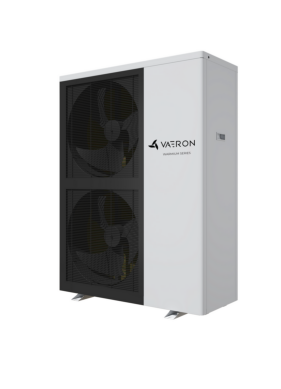

✅ Imagen selecionada para crear cotas desde https://media.adeo.com/media/qsi8uetrzxi1f5gy7qs8xuuj1ism75xjifjtery
Image saved at: imagenes_dameo_cotas/cod_mod_201054/98935772.png

📤 Subiendo imagen a Google Drive...
✅ Carpeta 'Pruebas_cotas' encontrada: 1ExFcpw8ztACfMtFDhZRbwAAhD0s-faNc
   📂 En unidad compartida: 0AD4cVfPueYs1Uk9PVA
   🔍 Buscando subcarpeta 'cod_mod_201054'...
   ✅ Subcarpeta encontrada: 1GbRPcccyiv_S0MoGYuSZSKkAkxZqkf37
   ✅ Imagen '98935772.png' subida correctamente
      📎 ID: 15D6kzqv9CHN_OT_pVSqJIjHH4UwIevkl
      🔗 Ver: https://drive.google.com/file/d/15D6kzqv9CHN_OT_pVSqJIjHH4UwIevkl/view?usp=drivesdk

✅ Imagen subida a Google Drive:
   🔗 https://drive.google.com/file/d/15D6kzqv9CHN_OT_pVSqJIjHH4UwIevkl/view?usp=drivesdk


In [ ]:
images = client.query(sql_get_images_dameo).to_dataframe()
cod_modelo = client.query(sql_mod_from_reference).to_dataframe().iloc[0]['cod_mod']

if images.empty:
    print(f"⚠️ No se encontraron imágenes para la referencia {reference}")
else:
    images_url = images['mediaLinkUrl'].tolist()
    image_parts = []
    images_bytes = []
    for idx, image_url in enumerate(images_url): 
        image_bytes, mime_type = download_image_from_url(image_url)
        
        if image_bytes:
            image = Image.open(BytesIO(image_bytes))
            images_bytes.append(image)
            # Display the image
            plt.figure(figsize=(1, 1))
            plt.imshow(image)
            plt.axis('off') # Hide the X and Y axes
            plt.show()
            
            # Agregar la imagen con su índice
            image_parts.append(Part.from_text(text=f"\n--- IMAGE {idx + 1} ---"))
            image_parts.append(Part.from_bytes(data=image_bytes, mime_type=mime_type))
            
            print(f"✅ Imagen descargada correctamente desde {image_url} con tipo MIME {mime_type}")

        else:
            print(f"⚠️ No se pudo descargar la imagen desde {image_url}")

    # Seleccionar la mejor imagen usando la función definida
    result = get_better_image_to_add_pattern(image_parts)
    selected_index = result['selected_index']
    selected_image = images_bytes[selected_index]
    
    plt.imshow(selected_image)
    plt.axis('off') # Hide the X and Y axes
    plt.show()
    print(f"✅ Imagen selecionada para crear cotas desde {images_url[selected_index]}")

    # Guardo la imagen en local
    # Define your path and filename
    folder_path = Path(FOLDER_IMAGES) / f"cod_mod_{cod_modelo}"
    file_path = folder_path / f"{reference}.png"
    # Create the directory (parents=True creates all missing folders in the path)
    folder_path.mkdir(parents=True, exist_ok=True)
    selected_image.save(file_path)
    print(f"Image saved at: {file_path}")

    # Save image in drive 
    
print(f"\n📤 Subiendo imagen a Google Drive...")
    
# Buscar carpeta padre
parent_folder_id = get_drive_folder_id(DRIVE_FOLDER_NAME)

if parent_folder_id:
    # Crear/encontrar subcarpeta por código de modelo
    subfolder_id = get_or_create_drive_subfolder(f"cod_mod_{cod_modelo}", parent_folder_id)
    
    # Subir imagen directamente desde memoria (sin guardar en disco)
    drive_file = upload_image_to_drive_from_memory(
        image=selected_image,
        file_name=f"{reference}.png",
        folder_id=subfolder_id
    )
    
else:
    print(f"❌ No se pudo encontrar la carpeta '{DRIVE_FOLDER_NAME}' en Google Drive")
    print(f"   💡 Asegúrate de que existe o créala manualmente")

## Obtener dimensiones de OPUS BigQuery

In [6]:
result.get('visible_dimensions', {})

{'width': True, 'height': True, 'depth': True}

In [7]:
dimension = client.query(sql_dimension_reference).to_dataframe()
# Puede haber duplicados en dimension, los quitamos
dimension = dimension.drop_duplicates(subset=['code_char'])
dimensiones = {dimension.loc[i, "name_char"]: dimension.loc[i, "value_char"] for i in dimension.index}
# Convert if it's a float AND has no decimals
dimensiones= {
    k: (int(v) if isinstance(v, float) and v.is_integer() else v) 
    for k, v in dimensiones.items()
}
dimensiones

/home/diego/.cache/pypoetry/virtualenvs/notebook-sy5XO1w4-py3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


{'Altura (en cm)': np.float64(137.8),
 'Anchura (en cm)': 105,
 'Profundidad (en cm)': 48}

## Generar pictograma


📐 Generando pictograma lineal a partir de la imagen seleccionada


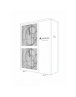

✅ Pictograma generado correctamente
   ✅ Imagen '98935772-pictogram.jpg' subida correctamente
      📎 ID: 1gVKuqOxpOJF9mGbBjentegs-w8JZN7BH
      🔗 Ver: https://drive.google.com/file/d/1gVKuqOxpOJF9mGbBjentegs-w8JZN7BH/view?usp=drivesdk

✅ Imagen subida a Google Drive:
   🔗 https://drive.google.com/file/d/1gVKuqOxpOJF9mGbBjentegs-w8JZN7BH/view?usp=drivesdk


In [ ]:
# Crear pictograma a partir de la imagen seleccionada
print(f"\n📐 Generando pictograma lineal a partir de la imagen seleccionada")
pictogram = get_pictogram_from_image(selected_image)
pictogram_image = Image.open(BytesIO(pictogram.candidates[0].content.parts[0].inline_data.data))
plt.figure(figsize=(5, 5))
plt.imshow(pictogram_image)
plt.axis('off') # Hide the X and Y axes
plt.show()
print("✅ Pictograma generado correctamente")

# Guardar pictograma localmente
folder_path = Path(FOLDER_IMAGES) / f"cod_mod_{cod_modelo}"
file_path = folder_path / f"{reference}-pictogram.jpg"
# Guardar la imagen
pictogram_image.save(file_path)

# Guardar drive 
drive_file = upload_image_to_drive_from_memory(
    image=selected_image,
    file_name=f"{reference}-pictogram.jpg",
    folder_id=subfolder_id
)


## Añadir cotas segun las dimensios obtenidas


📐 Dimensiones detectadas como visibles:
   • Anchura: ✓
   • Altura: ✓
   • Profundidad: ✓
📏 AÑADIENDO COTAS TÉCNICAS
🎯 Tipo de vista: 3D
📐 Dimensiones a añadir:
   • Anchura (en cm): 105 cm
   • Altura (en cm): 137.8 cm
   • Profundidad (en cm): 48 cm

=== TASK: ADD TECHNICAL DIMENSION LINES TO EXISTING PICTOGRAM ===

--- INPUT PROVIDED ---
1. **Pictogram Image**: The pictogram image
2. **Visible Dimensions**: Specific dimensions visible in this view (width, height, and/or depth)
3. **Dimension Values**: Exact measurements with units

--- CRITICAL REQUIREMENTS ---

**PRESERVE PICTOGRAM:**
✓ Only ADD dimension lines and text on the existing pictogram
✓ Do NOT redraw or modify the product illustration

**DIMENSION LINE STYLE:**

**IMPORTANT: Each dimension must consist of EXACTLY these components:**

1. **Dimension Line (ONE per dimension):**
   - ONE single continuous line from the edges of the product dimension being measured
   - Parallel to the dimension being measured
   - Solid b

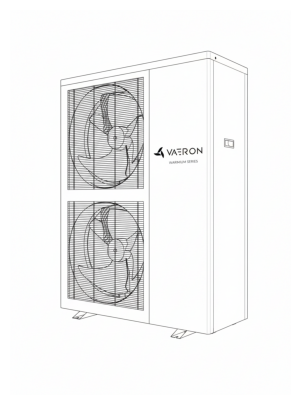

   ✅ Imagen '98935772-pictogram.jpg' subida correctamente
      📎 ID: 1Lhj8gxRKkUvDJBdFmuZK3xjEtC8ZRAiv
      🔗 Ver: https://drive.google.com/file/d/1Lhj8gxRKkUvDJBdFmuZK3xjEtC8ZRAiv/view?usp=drivesdk

✅ Imagen subida a Google Drive:
   🔗 https://drive.google.com/file/d/1Lhj8gxRKkUvDJBdFmuZK3xjEtC8ZRAiv/view?usp=drivesdk


In [ ]:


# Obtener las dimensiones visibles del resultado de selección de imagen
visible_dims = result.get('visible_dimensions', {})

print(f"\n📐 Dimensiones detectadas como visibles:")
print(f"   • Anchura: {'✓' if visible_dims.get('width') else '✗'}")
print(f"   • Altura: {'✓' if visible_dims.get('height') else '✗'}")
print(f"   • Profundidad: {'✓' if visible_dims.get('depth') else '✗'}")

# Generar imagen con cotas usando solo las dimensiones visibles
response = get_dimensions_added_from_pictogram(
    dimensiones=dimensiones,
    image=pictogram_image,
    visible_dimensions=visible_dims
)

if response:
    print("✅ Imagen con cotas generada correctamente")
else:
    print("⚠️ No se pudo generar la imagen con cotas")
    
# Extraer la imagen de la respuesta
if response and response.candidates:
    # Obtener la primera parte de la respuesta que contiene la imagen
    for part in response.candidates[0].content.parts:
        if part.inline_data:
            # Convertir los bytes de la imagen a PIL Image
            image_data = part.inline_data.data
            generated_image = Image.open(BytesIO(image_data))
            
            # Mostrar la imagen
            plt.figure(figsize=(5, 5))
            plt.imshow(pictogram_image)
            plt.axis('off') # Hide the X and Y axes
            plt.show()
            folder_path = Path(FOLDER_IMAGES) / f"cod_mod_{cod_modelo}"
            file_path = folder_path / f"{reference}-pat-01.jpg"
            # Guardar la imagen
            generated_image.save(file_path)
            # Guardar drive 
            drive_file = upload_image_to_drive_from_memory(
                image=selected_image,
                file_name=f"{reference}-pat-1.jpg",
                folder_id=subfolder_id
            )